In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from scipy import sparse
from sklearn.utils import check_array
from sklearn.metrics import mean_squared_error

random_seed = 42

# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self,
                 encoding='onehot',
                 categories='auto',
                 dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(
            np.arange(n_samples, dtype=np.int32), n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix(
            (data, (row_indices, column_indices)),
            shape=(n_samples, indices[-1]),
            dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values


def verify_stratified_split(col):
    print(col.value_counts() / len(col))

In [2]:
data = pd.read_csv('data/train.csv')

In [3]:
# Initial layout of the titanic data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


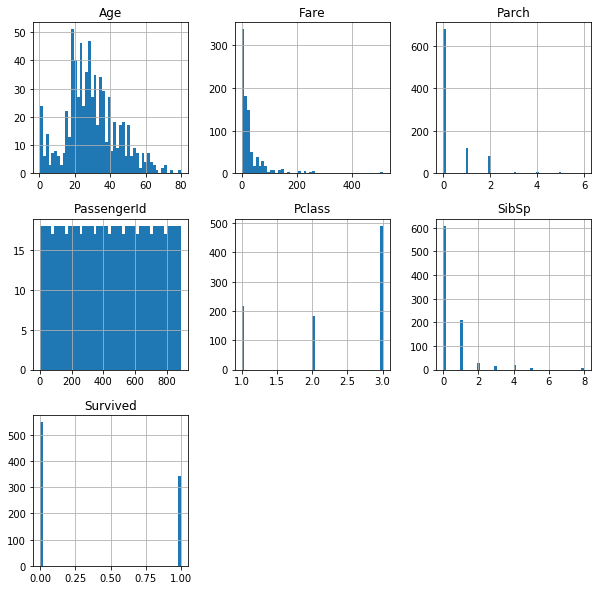

In [38]:
data.hist(bins=50,figsize=(10,10))
plt.show()

In [4]:
# Manual code cleanup.
data.drop(['Ticket', 'PassengerId', 'Name'], axis=1, inplace=True)  # Assumed to be of no interest
data.Sex = LabelEncoder().fit_transform(data.Sex)  # 0 = female, 1 = male
data.dropna(subset=["Embarked"], inplace=True)  # Only 2 values are nan

In [5]:
# Fill nan in ages. The mean strategy was chosen out of simplicity
data.Age.fillna(data.Age.mean(), inplace=True)  # mean (29.64) is close to median (28)

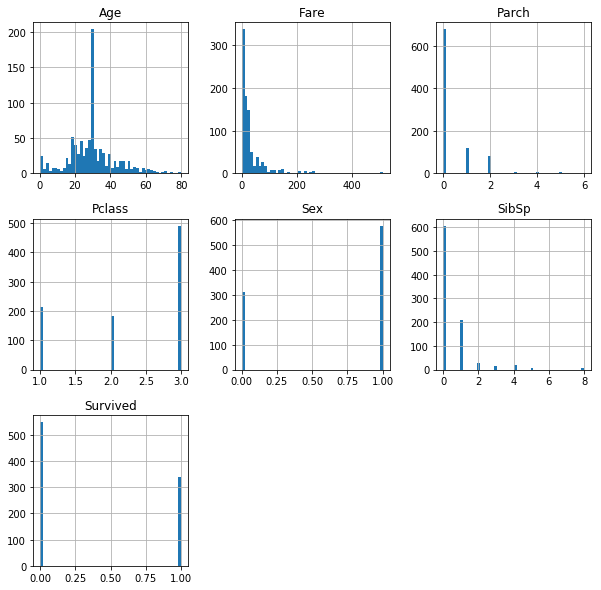

In [6]:
# Notice how the age distribution is skewed now, because of the 'mean' strategy
data.hist(bins=50,figsize=(10,10))
plt.show()

In [7]:
# Create an age category. PURELY ARBITRARY.
# I assume children categories might be more important, therefore finer grained.
# data["AgeCat10"] =  np.floor(data.Age / 10)
data["AgeCat"] = pd.cut(
    data.Age.fillna(-1),
    right=False,
    bins=[-10, 0, 5, 10, 15, 20, 30, 40, 50, 500],
    labels=['unknown', '0-5', '5-10', '10-15', '15-20', '20-30', '30-40', '40-50', '>=50'])

In [8]:
# Cabin categories
data["HasCabin"] = np.where(data.Cabin.isna(), 0, 1)
data["CabinLetter"] = data.Cabin.str.extract('([A-Z])', expand=False)  # Only keep first cabin letter if any
data["CabinNumber"] = data.Cabin.str.extract('[A-Z](\d+)', expand=False)  # Only keep first cabin number if any
data.CabinLetter.fillna('unknown', inplace=True)  # When no cabin, fill with X0
data.CabinNumber.fillna(-1, inplace=True)
data.CabinNumber = pd.to_numeric(data.CabinNumber)  # ANSME: Maybe convert to categories
data.CabinNumber = pd.cut(
    data.CabinNumber,
    right=False,
    bins=[-10, 0, 25, 50, 100, 150],
    labels=['unknown', '1-25', '25-50', '50-100', '100-150'])
data.drop(['Cabin'], axis=1, inplace=True)

In [9]:
# Watch out: T, G, F, A have low counts. Might not have much value...
data.CabinLetter.value_counts()

unknown    687
C           59
B           45
D           33
E           32
A           15
F           13
G            4
T            1
Name: CabinLetter, dtype: int64

In [11]:
# Stratified Shuffle Split
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=random_seed)
for train_index, test_index in strat_split.split(
        data, data[['Sex','AgeCat']]):  # TODO Add pClass. w/ pClass cannot do split
                                        # because outer products leads to a bin of 1
    train_data_idx = train_index
    test_data_idx = test_index
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]

In [12]:
# Pipeline
num_attribs = ["Sex", "Age", "SibSp", "Parch", "Fare", "HasCabin"]
cat_attribs = ["Pclass", "Embarked", "AgeCat", "CabinLetter", "CabinNumber"]
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler())])
cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)),
                         ('cat_encoder',
                          CategoricalEncoder(encoding="onehot-dense"))])
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)])

In [13]:
# Prepare data for learning models
train_data_prepared = full_pipeline.fit_transform(train_data)
test_data_prepared = full_pipeline.transform(test_data)  # NOTE: use of transform() only. do not refit.

In [16]:
# 1. Baseline model: The female prediction model
female_train_data_accuracy = sum(train_data.Sex != train_data.Survived)/len(train_data)
female_test_data_accuracy = sum(test_data.Sex != test_data.Survived)/len(test_data)
print("(female) training set accuracy = %.4f" % female_train_data_accuracy)
print("(female) test     set accuracy = %.4f" % female_test_data_accuracy)

(female) training set accuracy = 0.7937
(female) test     set accuracy = 0.7191


In [17]:
# 2. Linear regression model: Not suited for classification, but what the heck!
lin_reg = LinearRegression()
lin_reg.fit(train_data_prepared, train_data.Survived)

train_data_predictions = np.where(lin_reg.predict(train_data_prepared) > .5, 1, 0)
test_data_predictions = np.where(lin_reg.predict(test_data_prepared) > .5, 1, 0)
lin_reg_train_data_accuracy = sum(train_data_predictions == train_data.Survived)/len(train_data)
lin_reg_test_data_accuracy = sum(test_data_predictions == test_data.Survived)/len(test_data)
# ANSME How to do an anova analysis of the parameters?
print("(lin. reg.) training set accuracy = %.4f" % lin_reg_train_data_accuracy)
print("(lin. reg.) test     set accuracy = %.4f" % lin_reg_test_data_accuracy)

(lin. reg.) training set accuracy = 0.7975
(lin. reg.) test     set accuracy = 0.6854
